In [1]:
# import expiration data
import csv
reader = csv.DictReader(open("expiration_data.csv"))
expiration = []
for line in reader:
    expiration.append(line)
for i in range(len(expiration)):
    expiration[i] = dict(expiration[i])
    
# import recipe
import csv
reader = csv.DictReader(open("recipe.csv"))
recipe = []
for line in reader:
    recipe.append(line)
for i in range(len(recipe)):
    recipe[i] = dict(recipe[i])

# import foodlist
foodList = open("foodList.txt")
foodList = foodList.readlines()
for i in range(len(foodList)):
    foodList[i] = foodList[i][:-1]

In [2]:
len(recipe)

20111

In [3]:
#from pattern.text.en import singularize
# user: list of dictionaries
# epiration: list of dictionaries
# destructively append "expiration date" to each dictionary in "user" 
def addExpirationDates(user, expiration):
    for userItem in user:
        if 'name' in userItem.keys():
            curr = userItem['name']
            curr_split = curr.split(' ')
            curr_max = [0, float('inf')]
            exactMatched = False
            for expItem in expiration:

                # exact match
                if curr == expItem['name']:
                    userItem['expireIn'] = int(expItem['expireIn'])
                    exactMatched = True
                    break

                # split into set and find the maximum number of names that also exist in expiration data
                expItem_split = expItem['name'].split(' ')
                # calculate curr overlap score
                overlapped = 0
                for i in curr_split:
                    if i in expItem_split:
                        overlapped += 1
                if overlapped > curr_max[0]:
                    curr_max = [overlapped, int(expItem['expireIn'])]
                elif overlapped == curr_max[0]:
                    curr_max[1] = min(curr_max[1], int(expItem['expireIn']))
            if curr_max[0] > 0:
                userItem['expireIn'] = curr_max[1]
            # if no matching found, set -1 as indicator value
            elif not exactMatched:
                userItem['expireIn'] = -1

In [4]:
def generate_parsed(item, foodList):
    results = []
    if item in foodList:
        results += [item]
    else:
        for w in item.split(' '):
            if w in foodList:
                results += [w]
    return list(set(results))

In [5]:
def addParsedUserData(user, foodList):
    for item in user:
        if 'name' in item.keys():
            item['parsed_name'] = generate_parsed(item['name'], foodList)

In [6]:
def calculateOverlapScore(user, recipe_item):
    score = 0
    for userItem in user:
        if 'parsed_name' in userItem.keys():
            for i in userItem['parsed_name']:
                if i in recipe_item['ingredients_processed']:
                    score += 1
    return score

In [7]:
def calculateExpireScore(user, recipe_item):
    score = 0
    for userItem in user:
        if 'parsed_name' in userItem.keys():
            for i in userItem['parsed_name']:
                if i in recipe_item['ingredients_processed']:
                    score += (1 / userItem['expireIn']) ** 2
    return score

In [8]:
# due to replicate recipe in recipe data, remove replicate item in top_5
def checkRepeated(recipe_item, curr_list):
    for i in curr_list:
        if recipe_item['title'] == i[0]['title']:
            return True
    return False

In [9]:
def top_5(user, recipe):
    top_5 = []
    min_score = float('inf')
    min_index = 0
    for recipe_item in recipe:
        if checkRepeated(recipe_item, top_5):
            continue
        curr_score = calculateOverlapScore(user, recipe_item) + 10 * calculateExpireScore(user, recipe_item)
        if len(top_5) < 5:
            top_5 += [[recipe_item, curr_score]]
            if curr_score < min_score:
                min_score = curr_score
                min_index = len(top_5) - 1
        else:
            if curr_score > min_score:
                top_5[min_index] = [recipe_item, curr_score]
                new_min = float('inf')
                for i in range(5):
                    if top_5[i][1] < new_min:
                        new_min = top_5[i][1]
                        min_index = i
                min_score = new_min
    return top_5

In [10]:
# create user data dictionary given a list of scanned food names and return user data
def createUserDict(names):
    user = []
    for name in names:
        user += [{'name': name}]
    addExpirationDates(user, expiration)
    addParsedUserData(user, foodList)
    return user

In [11]:
import copy
def continuousTop5(user, recipe):
    #nonlocal recipe_copy
    recipe_copy = copy.deepcopy(recipe)
    def g():
        curr = top_5(user, recipe_copy)
        for i in curr:
            recipe_copy.remove(i[0])
        return curr
    return g

In [12]:
# example usage: input a list of scanned food names (l), create the processed user data by calling createUserDict
l = ['olive', 'cheese', 'mozzarella', 'flour', 'pepperoni', 'sausage', 'yeast', 'ham', 'dough', 'pineapple', 'artichoke']
user = createUserDict(l)
#Sample user data (a list of dictionaries)
user

[{'name': 'olive', 'expireIn': 60, 'parsed_name': ['olive']},
 {'name': 'cheese', 'expireIn': 7, 'parsed_name': ['cheese']},
 {'name': 'mozzarella', 'expireIn': 360, 'parsed_name': ['mozzarella']},
 {'name': 'flour', 'expireIn': 30, 'parsed_name': []},
 {'name': 'pepperoni', 'expireIn': -1, 'parsed_name': ['pepperoni']},
 {'name': 'sausage', 'expireIn': 1, 'parsed_name': ['sausage']},
 {'name': 'yeast', 'expireIn': 5, 'parsed_name': ['yeast']},
 {'name': 'ham', 'expireIn': 3, 'parsed_name': ['ham']},
 {'name': 'dough', 'expireIn': -1, 'parsed_name': []},
 {'name': 'pineapple', 'expireIn': 720, 'parsed_name': ['pineapple']},
 {'name': 'artichoke', 'expireIn': 2, 'parsed_name': ['artichoke']}]

In [13]:
#use recipe_generator to generate suggestions
recipe_generator = continuousTop5(user, recipe)
# return a list of lists where each item is a recipe and score pair (format: [recipe, score], where recipe is a dictionary and score is the recommendation score)
curr_5 = recipe_generator()
curr_5

[[{'directions': "['In a small bowl whisk together the garlic, the vinegars, the rosemary, the basil, the orégano, the red pepper flakes, and salt and pepper to taste, add the oil in a stream, whisking, and whisk the marinade until it is emulsified.', 'In a large saucepan of boiling water blanch the carrots and the fennel for 3 to 4 minutes, or until they are crisp-tender, drain them, and plunge them into a bowl of ice and cold water. Let the vegetables cool and drain them well. In a large bowl toss together the carrots, the fennel, the roasted peppers, the peperoncini, the olives, the sun-dried tomatoes, the bocconcini, the pepperoni, the artichoke hearts, the marinade, the minced parsley until the antipasto is combined well and chill the antipasto, covered, for at least 4 hours or overnight. Transfer the antipasto to a platter, garnish it with the parsley sprigs, and serve it at room temperature.']",
   'fat': '55.0',
   'date': '2004-08-20T04:00:00.000Z',
   'categories': "['Olive',

In [14]:
#call recipe_generator() again to generate the next 5 ranked recipe suggestion
next_5 = recipe_generator()
next_5

[[{'directions': "['In the large bowl of an electric mixer proof the yeast with the sugar in 1/3 cup of the water for 5 minutes, or until the mixture is foamy, stir in the remaining 1/3 cup water, the oil, 2 cups of the flour, and the salt, and blend the mixture until it forms a dough. Fit the mixer with the dough hook and knead the dough, incorporating as much of the remaining 1/4 cup flour as necessary to prevent the dough from sticking, for 3 minutes, or until it is smooth and elastic. Transfer the dough to an oiled bowl and turn it to coat it with the oil. Let the dough rise, covered with plastic wrap, in a warm place for 1 hour, or until it is double in bulk, and punch it down.', 'Divide the dough into 6 pieces and on a floured surface roll out each piece into a 6-inch round. Transfer the rounds to baking sheets (preferably black steel, for a crisper crust), oiled and sprinkled with the cornmeal, and spread each of the rounds with a scant 1 tablespoon of the tomato sauce. Sprinkle

In [15]:
def find_category(s):
    result = []
    s = s[1:s.find(']')]
    s = s.replace('"', "'")
    front = 0
    while front < len(s):
        s = s[front+1:]
        end = s.find("'")
        result.append(s[0:end])
        front = end + 3
    return result

In [16]:
def add_category(user, recipe):
    categories = recipe['categories']
    for category in find_category(categories):
        found = False
        for user_item in user:
            if category in user_item.keys():
                user_item[category] += 1
                found = True
        if not found:
            user.append({category: 1})

In [17]:
#sample usage for adding user profile
add_category(user, recipe[0]) #assume the user marked the recipe[0] as cooked

In [18]:
#the type of the first recipe includes Sandwich, Bean, ..., Cookie  We add a weight of one to each category
user

[{'name': 'olive', 'expireIn': 60, 'parsed_name': ['olive']},
 {'name': 'cheese', 'expireIn': 7, 'parsed_name': ['cheese']},
 {'name': 'mozzarella', 'expireIn': 360, 'parsed_name': ['mozzarella']},
 {'name': 'flour', 'expireIn': 30, 'parsed_name': []},
 {'name': 'pepperoni', 'expireIn': -1, 'parsed_name': ['pepperoni']},
 {'name': 'sausage', 'expireIn': 1, 'parsed_name': ['sausage']},
 {'name': 'yeast', 'expireIn': 5, 'parsed_name': ['yeast']},
 {'name': 'ham', 'expireIn': 3, 'parsed_name': ['ham']},
 {'name': 'dough', 'expireIn': -1, 'parsed_name': []},
 {'name': 'pineapple', 'expireIn': 720, 'parsed_name': ['pineapple']},
 {'name': 'artichoke', 'expireIn': 2, 'parsed_name': ['artichoke']},
 {'Sandwich': 1},
 {'Bean': 1},
 {'Fruit': 1},
 {'Tomato': 1},
 {'turkey': 1},
 {'Vegetable': 1},
 {'Kid-Friendly': 1},
 {'Apple': 1},
 {'Lentil': 1},
 {'Lettuce': 1},
 {'Cookie': 1}]

In [19]:
#if the user cooks recipe[0] again, the weight of each category will increase by 1
add_category(user, recipe[0])
user

[{'name': 'olive', 'expireIn': 60, 'parsed_name': ['olive']},
 {'name': 'cheese', 'expireIn': 7, 'parsed_name': ['cheese']},
 {'name': 'mozzarella', 'expireIn': 360, 'parsed_name': ['mozzarella']},
 {'name': 'flour', 'expireIn': 30, 'parsed_name': []},
 {'name': 'pepperoni', 'expireIn': -1, 'parsed_name': ['pepperoni']},
 {'name': 'sausage', 'expireIn': 1, 'parsed_name': ['sausage']},
 {'name': 'yeast', 'expireIn': 5, 'parsed_name': ['yeast']},
 {'name': 'ham', 'expireIn': 3, 'parsed_name': ['ham']},
 {'name': 'dough', 'expireIn': -1, 'parsed_name': []},
 {'name': 'pineapple', 'expireIn': 720, 'parsed_name': ['pineapple']},
 {'name': 'artichoke', 'expireIn': 2, 'parsed_name': ['artichoke']},
 {'Sandwich': 2},
 {'Bean': 2},
 {'Fruit': 2},
 {'Tomato': 2},
 {'turkey': 2},
 {'Vegetable': 2},
 {'Kid-Friendly': 2},
 {'Apple': 2},
 {'Lentil': 2},
 {'Lettuce': 2},
 {'Cookie': 2}]

In [20]:
recipe[0]

{'directions': "['1. Place the stock, lentils, celery, carrot, thyme, and salt in a medium saucepan and bring to a boil. Reduce heat to low and simmer until the lentils are tender, about 30 minutes, depending on the lentils. (If they begin to dry out, add water as needed.) Remove and discard the thyme. Drain and transfer the mixture to a bowl; let cool.', '2. Fold in the tomato, apple, lemon juice, and olive oil. Season with the pepper.', '3. To assemble a wrap, place 1 lavash sheet on a clean work surface. Spread some of the lentil mixture on the end nearest you, leaving a 1-inch border. Top with several slices of turkey, then some of the lettuce. Roll up the lavash, slice crosswise, and serve. If using tortillas, spread the lentils in the center, top with the turkey and lettuce, and fold up the bottom, left side, and right side before rolling away from you.']",
 'fat': '7.0',
 'date': '2006-09-01T04:00:00.000Z',
 'categories': "['Sandwich', 'Bean', 'Fruit', 'Tomato', 'turkey', 'Veget

In [21]:
all_category = []
for i in recipe:
    c = i['categories']
    all_category += find_category(c)
all_category = set(all_category)

In [22]:
len(all_category)

676

In [23]:
all_fat = []
for i in recipe:
    f = i['fat']
    all_fat.append(f)
all_fat

['7.0',
 '23.0',
 '7.0',
 '',
 '32.0',
 '79.0',
 '',
 '',
 '10.0',
 '41.0',
 '5.0',
 '',
 '48.0',
 '12.0',
 '3.0',
 '31.0',
 '5.0',
 '68.0',
 '7.0',
 '33.0',
 '19.0',
 '',
 '',
 '',
 '30.0',
 '7.0',
 '20.0',
 '0.0',
 '19.0',
 '5.0',
 '',
 '',
 '18.0',
 '13.0',
 '',
 '44.0',
 '',
 '10.0',
 '16.0',
 '6.0',
 '35.0',
 '31.0',
 '',
 '',
 '',
 '0.0',
 '8.0',
 '',
 '21.0',
 '1.0',
 '12.0',
 '13.0',
 '',
 '87.0',
 '7.0',
 '',
 '70.0',
 '10.0',
 '3.0',
 '7.0',
 '6.0',
 '32.0',
 '15.0',
 '19.0',
 '7.0',
 '',
 '12.0',
 '20.0',
 '59.0',
 '5.0',
 '42.0',
 '37.0',
 '36.0',
 '24.0',
 '14.0',
 '56.0',
 '0.0',
 '7.0',
 '8.0',
 '',
 '73.0',
 '12.0',
 '57.0',
 '18.0',
 '54.0',
 '28.0',
 '',
 '77.0',
 '11.0',
 '',
 '',
 '37.0',
 '17.0',
 '3.0',
 '70.0',
 '34.0',
 '8.0',
 '52.0',
 '9.0',
 '8.0',
 '7.0',
 '',
 '25.0',
 '',
 '10.0',
 '10.0',
 '11.0',
 '25.0',
 '',
 '73.0',
 '18.0',
 '0.0',
 '',
 '18.0',
 '0.0',
 '',
 '0.0',
 '60.0',
 '0.0',
 '0.0',
 '1.0',
 '36.0',
 '7.0',
 '',
 '7.0',
 '28.0',
 '16.0',
 '',

In [24]:
all_sodium = []
for i in recipe:
    s = i['sodium']
    all_sodium.append(s)
all_sodium

['559.0',
 '1439.0',
 '165.0',
 '',
 '452.0',
 '1042.0',
 '',
 '',
 '1272.0',
 '1696.0',
 '30.0',
 '',
 '439.0',
 '176.0',
 '1394.0',
 '977.0',
 '160.0',
 '1027.0',
 '344.0',
 '383.0',
 '423.0',
 '',
 '',
 '',
 '206.0',
 '103.0',
 '250.0',
 '0.0',
 '79.0',
 '226.0',
 '',
 '',
 '604.0',
 '765.0',
 '',
 '1248.0',
 '',
 '329.0',
 '413.0',
 '208.0',
 '100.0',
 '181.0',
 '',
 '',
 '',
 '881.0',
 '815.0',
 '',
 '174.0',
 '4.0',
 '508.0',
 '242.0',
 '',
 '583.0',
 '148.0',
 '',
 '1413.0',
 '211.0',
 '697.0',
 '116.0',
 '60.0',
 '112.0',
 '565.0',
 '694.0',
 '89.0',
 '',
 '340.0',
 '155.0',
 '148.0',
 '469.0',
 '637.0',
 '907.0',
 '231.0',
 '84.0',
 '599.0',
 '569.0',
 '364.0',
 '9.0',
 '51.0',
 '',
 '220.0',
 '199.0',
 '909.0',
 '20.0',
 '1797.0',
 '1038.0',
 '',
 '311.0',
 '146.0',
 '',
 '',
 '106.0',
 '826.0',
 '603.0',
 '1226.0',
 '302.0',
 '77.0',
 '324.0',
 '46.0',
 '91.0',
 '635.0',
 '',
 '89.0',
 '',
 '73.0',
 '185.0',
 '210.0',
 '1237.0',
 '',
 '150.0',
 '515.0',
 '1430.0',
 '',
 '587

In [25]:
all_calories = []
for i in recipe:
    c = i['calories']
    all_calories.append(c)
all_calories

['426.0',
 '403.0',
 '165.0',
 '',
 '547.0',
 '948.0',
 '',
 '',
 '170.0',
 '602.0',
 '256.0',
 '',
 '766.0',
 '174.0',
 '134.0',
 '382.0',
 '146.0',
 '890.0',
 '107.0',
 '421.0',
 '345.0',
 '',
 '',
 '',
 '279.0',
 '95.0',
 '215.0',
 '14.0',
 '351.0',
 '311.0',
 '',
 '',
 '376.0',
 '185.0',
 '',
 '625.0',
 '',
 '107.0',
 '336.0',
 '145.0',
 '483.0',
 '634.0',
 '',
 '',
 '',
 '90.0',
 '202.0',
 '',
 '338.0',
 '191.0',
 '166.0',
 '275.0',
 '',
 '1203.0',
 '266.0',
 '',
 '904.0',
 '223.0',
 '194.0',
 '177.0',
 '70.0',
 '368.0',
 '293.0',
 '523.0',
 '252.0',
 '',
 '224.0',
 '185.0',
 '830.0',
 '195.0',
 '684.0',
 '641.0',
 '538.0',
 '264.0',
 '365.0',
 '926.0',
 '26.0',
 '230.0',
 '157.0',
 '',
 '1172.0',
 '298.0',
 '682.0',
 '517.0',
 '856.0',
 '599.0',
 '',
 '1143.0',
 '129.0',
 '',
 '',
 '571.0',
 '508.0',
 '62.0',
 '1118.0',
 '306.0',
 '209.0',
 '645.0',
 '126.0',
 '133.0',
 '285.0',
 '',
 '310.0',
 '',
 '248.0',
 '247.0',
 '201.0',
 '519.0',
 '',
 '1076.0',
 '338.0',
 '298.0',
 '',
 

In [80]:
all_proteins = []
for i in recipe:
    c = i['protein']
    all_proteins.append(c)
all_proteins

['30.0',
 '18.0',
 '6.0',
 '',
 '20.0',
 '19.0',
 '',
 '',
 '7.0',
 '23.0',
 '4.0',
 '',
 '12.0',
 '11.0',
 '4.0',
 '5.0',
 '4.0',
 '59.0',
 '5.0',
 '10.0',
 '11.0',
 '',
 '',
 '',
 '3.0',
 '1.0',
 '6.0',
 '0.0',
 '6.0',
 '5.0',
 '',
 '',
 '7.0',
 '10.0',
 '',
 '39.0',
 '',
 '4.0',
 '44.0',
 '3.0',
 '5.0',
 '44.0',
 '',
 '',
 '',
 '2.0',
 '19.0',
 '',
 '14.0',
 '3.0',
 '8.0',
 '6.0',
 '',
 '89.0',
 '4.0',
 '',
 '38.0',
 '4.0',
 '2.0',
 '5.0',
 '2.0',
 '6.0',
 '7.0',
 '8.0',
 '4.0',
 '',
 '21.0',
 '0.0',
 '9.0',
 '7.0',
 '21.0',
 '39.0',
 '8.0',
 '7.0',
 '19.0',
 '9.0',
 '1.0',
 '2.0',
 '3.0',
 '',
 '54.0',
 '6.0',
 '36.0',
 '7.0',
 '45.0',
 '48.0',
 '',
 '63.0',
 '4.0',
 '',
 '',
 '36.0',
 '45.0',
 '2.0',
 '92.0',
 '0.0',
 '5.0',
 '22.0',
 '3.0',
 '2.0',
 '19.0',
 '',
 '3.0',
 '',
 '3.0',
 '5.0',
 '4.0',
 '14.0',
 '',
 '11.0',
 '15.0',
 '1.0',
 '',
 '13.0',
 '1.0',
 '',
 '1.0',
 '21.0',
 '1.0',
 '0.0',
 '3.0',
 '55.0',
 '2.0',
 '',
 '5.0',
 '2.0',
 '3.0',
 '',
 '21.0',
 '17.0',
 '16.0'

In [26]:
type(recipe[0]['categories'])

str

In [27]:
for i in recipe:
    if 'Healthy' in i['categories']:
        print(i['title'])

Mahi-Mahi in Tomato Olive Sauce 
Ham and Spring Vegetable Salad with Shallot Vinaigrette 
Raw Cream of Spinach Soup 
Fish Fillets in Parchment with Asparagus and Orange 
Dried Pear Crisps 
Baked Halibut with Orzo, Spinach, and Cherry Tomatoes 
Grilled Beef, Jícama, and Apple Salad 
Braised Chicken With Artichokes and Olives 
Collard-and-Prosciutto Chicken Roulades Over Watercress Salad 
Chicken in Green Pumpkin-Seed Sauce 
Salmon with Chili-Mango Salsa 
Savoy Cabbage and Arugula Salad 
Grilled Steak Salad with Beets and Scallions 
Roasted Bell Pepper Halves Stuffed with Bulgur and Spinach 
Gnocchi with Tomato, Basil, and Olives 
Roasted Root Vegetables 
Thai Vegetables 
Creamy Tofu Salad 
Potato Gnocchi with Shrimp and Peas 
Mackerel with Crushed Potatoes and Oregano 
Roasted Winter Squash and Parsnips with Maple Syrup Glaze and Marcona Almonds 
Snapper Escabèche with Charred Scallions 
Lemon-Parsley Linguine 
Banana Smoothie 
Yellow Squash and Bell Pepper Torte 
Orange Cranberry Bundt

Roasted Bell Pepper Salad with Pine Nuts 
Bruschetta with Arugula, Smoked Mozzarella, and Tomatoes 
Summer Vegetable Stir-Fry with Couscous 
Lentil Soup with Roasted Vegetables 
Vegetable Ragoût with Cumin and Ginger 
Breaded Chicken Cutlets with Chunky Vegetable Sauce 
Seared Arctic Char with Broccolini, Olives, and Garlic 
Steak with Olives 
Carrot-Coconut Soup 
Lemon and Fresh Herb Tabbouleh 
Spinach and Roasted Beet Salad with Ginger Vinaigrette 
Chicken Breasts with Tomato-Herb Pan Sauce 
Slow-Cooked Onion Salad 
Creamy Farfalle with Salmon and Peas 
Marinated Eggplant with Capers and Mint 
Broccoli Slaw with Miso-Ginger Dressing 
Baked Mustard-Crusted Salmon With Asparagus and Tarragon 
Roasted Beet Soup with Potato and Dill Salad 
Apricot Frozen Yogurt 
Root Vegetable Soup Drizzled with Truffle Oil 
White Bean and Halibut Stew 
Grilled Vegetable Flatbreads Stuffed with Zucchini, Eggplant, and Tomato 
Turkey Shawarma with Tomato Relish and Tahini Sauce 
Pear-Cranberry Cobblers 
C

In [28]:
import numpy as np
from matplotlib import pyplot as plt

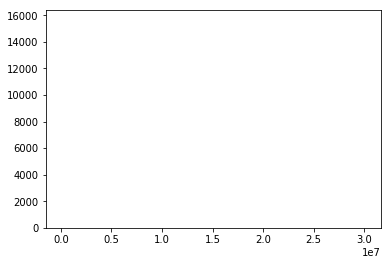

In [39]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
num_bins = len(calories)
n, bins, patches = plt.hist(np.array(calories), num_bins, facecolor='blue', alpha=0.5)
plt.show()

(array([8522., 5184., 2894., 1580.,  853.,  442.,  260.,  190.,  109.,
          77.]),
 array([   0. ,  199.3,  398.6,  597.9,  797.2,  996.5, 1195.8, 1395.1,
        1594.4, 1793.7, 1993. ]),
 <a list of 10 Patch objects>)

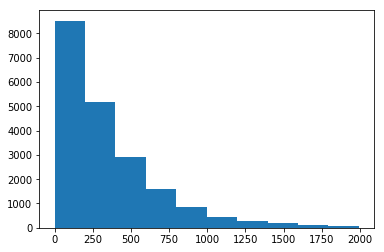

In [90]:
calories = []
for i in range(len(all_calories)):
    if all_calories[i] and int(float(all_calories[i])) < 2000:
        calories.append(int(float(all_calories[i])))
    else:
        calories.append(0)
plt.hist(np.array(calories))

(array([11515.,  2829.,  1830.,  1229.,   916.,   582.,   477.,   328.,
          235.,   170.]),
 array([   0. ,  199.7,  399.4,  599.1,  798.8,  998.5, 1198.2, 1397.9,
        1597.6, 1797.3, 1997. ]),
 <a list of 10 Patch objects>)

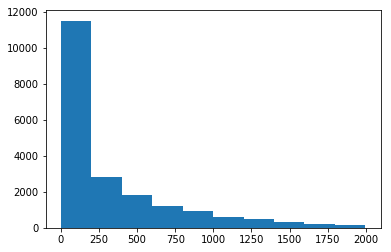

In [91]:
sodium = []
for i in range(len(all_sodium)):
    if all_sodium[i] and int(float(all_sodium[i])) < 2000:
        sodium.append(int(float(all_sodium[i])))
    else:
        sodium.append(0)
plt.hist(np.array(sodium))

(array([13077.,  4085.,  1505.,   731.,   310.,   176.,    85.,    65.,
           41.,    36.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

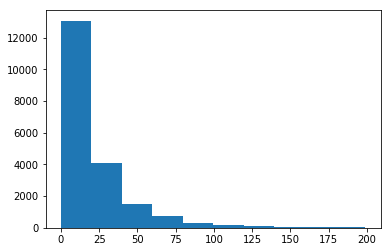

In [92]:
fat = []
for i in range(len(all_fat)):
    if all_fat[i] and int(float(all_fat[i])) < 200:
        fat.append(int(float(all_fat[i])))
    else:
        fat.append(0)
plt.hist(np.array(fat))

(array([13237.,  2338.,  1316.,  1104.,   823.,   492.,   303.,   224.,
          167.,   107.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

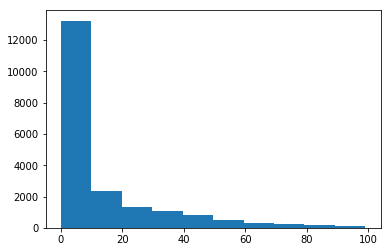

In [93]:
protein = []
for i in range(len(all_proteins)):
    if all_proteins[i] and int(float(all_proteins[i])) < 100:
        protein.append(int(float(all_proteins[i])))
    else:
        protein.append(0)
plt.hist(np.array(protein))

In [106]:
healthy = []
for i in range(len(protein)):
    if calories[i] != 0 and calories[i] < np.average(calories) \
    and sodium[i] != 0 and sodium[i] < np.average(sodium) \
    and fat[i] != 0 and fat[i] < np.average(fat) \
    and protein[i] != 0 and protein[i] > np.average(protein):
        healthy.append(i)
healthyRecipe = []
for i in range(len(healthy)):
    healthyRecipe.append(recipe[healthy[i]])

In [109]:
# recommend healthy recipes based on user data
def recommendHealthy(user, healthyRecipe):
    max_score = -float('inf')
    curr = []
    for recipe_item in healthyRecipe:
        curr_score = calculateOverlapScore(user, recipe_item) + 10 * calculateExpireScore(user, recipe_item)
        if curr_score > max_score:
            curr = [[recipe_item, curr_score]]
            max_score = curr_score
    return curr

In [110]:
recommendHealthy(user, healthyRecipe)

[[{'directions': "['Prepare barbecue (medium heat). Sauté chorizo in large skillet over medium-high heat until cooked through, breaking up with spoon, about 8 minutes. Transfer chorizo to sieve set over bowl and drain. Mix 2 1/2 cups watercress and goat cheese in medium bowl.', 'Lightly brush 1 side of each pita bread with oil. Grill, oiled side down, until bottom is just crisp, about 2 minutes. Transfer to work surface, grilled side up. Cover each pita bread with cheese mixture, chorizo, and several sweet pepper rings, dividing equally.', 'Return pita pizzas to barbecue. Grill, covered, until goat cheese softens, about 2 minutes. Transfer pita pizzas to serving platter. Top each with more watercress and serve.']",
   'fat': '13.0',
   'date': '2006-07-10T22:18:42.000Z',
   'categories': "['Pepper', 'Low Cal', 'Goat Cheese', 'Sausage', 'Summer', 'Grill/Barbecue', 'Watercress', 'Bon Appétit']",
   'calories': '234.0',
   'desc': 'For a vegetarian version, substitute Soyrizo for the chor

In [52]:
len(recipe)

20111